<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/inferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook does the second step in the split workflow on Terra**

The NIFTI files generated from first step are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###**Installing Packages**

In [ ]:
%%capture
#Installing lz4 for compression/decompression
#xvfb required for previewing Totalsegmentator png images
!apt-get install lz4 xvfb

In [ ]:
%%capture
#Installing Totalsegmentator for Inference
#pyradiomics required for extracting radiomics features 
#nvidia-ml-py3 for capturing gpu utilization
!pip install TotalSegmentator pyradiomics nvidia-ml-py3

###**Importing Packages**

In [ ]:
import glob
import os
import sys
import shutil
from pathlib import Path
import time
import subprocess
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import nvidia_smi


curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Thu May  4 19:29:53 2023

Current directory :/content
Python version    : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


###**Parameters for Papermill**

In [ ]:
converterType='dcm2niix'
niftiFilePath=''

###**Local testing**

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown "https://drive.google.com/uc?id=1LsRPn_gTWUwVZwrcnSllogTaw8MW2d2M" 
niftiFilePath= glob.glob("*.lz4")[0]

Downloading...
From: https://drive.google.com/uc?id=1LsRPn_gTWUwVZwrcnSllogTaw8MW2d2M
To: /content/_1_downloadDicomAndConvertNiftiFiles.tar.lz4
100% 464M/464M [00:06<00:00, 67.6MB/s]


###**Decompressing NIFTI files from first step**

In [ ]:
!lz4 -d {niftiFilePath} -c | tar  --strip-components=0  -xvf -

dcm2niix/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.11872245252939435071116658934_1_OPA_GE_LSPR16_STANDARD_330_2.5_120_80_58.2_1.4_20000102000000_2.nii.gz
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/
dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2.nii.gz
dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/
dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2.nii.gz
dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/
dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654

###**Defining Functions**

In [ ]:
#create directory for TotalSegmentator Output files
try:
  shutil.rmtree('Inference')
  #shutil.rmtree('metadata')
except OSError:
  pass
os.mkdir('Inference')
#os.mkdir('metadata')

In [ ]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True
        self.working_disk_path = self.get_working_disk_path()

    def get_working_disk_path(self):
        partitions = psutil.disk_partitions()
        for partition in partitions:
            if partition.mountpoint == '/':
                return '/'
            elif '/cromwell_root' in partition.mountpoint:
                return '/cromwell_root'
        return '/'  # Default to root directory if no specific path is found
    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_usage = psutil.disk_usage(self.working_disk_path)
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

In [ ]:
def check_total_segmentator_errors(series_id):
    try:
        # Check if the output files from TotalSegmentator exist
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/segmentations.nii")
        # assert os.path.exists(f"{curr_dir}/Inference/{series_id}/statistics_radiomics.json")
        # assert os.path.exists(f"{curr_dir}/Inference/{series_id}/preview_total.png")
    except AssertionError:
        # If any of the output files do not exist, log an error
        with open('totalsegmentator_errors.txt', 'a') as f:
            f.write(f"Error: TotalSegmentator failed for series {series_id}\n")
        return True
    return False

In [ ]:
def inferenceTotalSegmentator(series_id):
      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'metadata/{series_id}')
        os.remove('segmentations.nii.gz')
        os.remove('statistics_radiomics.json')
        os.remove('preview_total.png')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')

      print("Processing series: "+series_id)  

      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
  
      start_time = time.time()
      #!TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --fast --preview  --radiomics 
      result=subprocess.run(['TotalSegmentator', '-i', nifti_filename_path, '-o', 'segmentations', '--ml'],stdout=subprocess.PIPE, stderr=subprocess.PIPE,  universal_newlines=True)
      print(result.stdout)
      total_segmentator_time = time.time() - start_time



      try:
        subprocess.run(["mv",  f"{curr_dir}/segmentations.nii", f"{curr_dir}/Inference/{series_id}/"], check=True)
        print("Files moved successfully using the first command")
      except subprocess.CalledProcessError:
        try:
            subprocess.run(["mv",  "segmentations/segmentations.nii", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
        except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")

 
      check_total_segmentator_errors(series_id)  
      
      #!mv {curr_dir}/preview_total.png {curr_dir}/segmentations.nii {curr_dir}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/
      !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii
      # !mv {curr_dir}/Inference/{series_id}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json      
      # !mv {curr_dir}/Inference/{series_id}/preview_total.png {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png

      
      start_time = time.time()  
      !lz4 --rm {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
      #!tar cvf - -C {curr_dir}/Inference/{series_id} {series_id}_statistics_radiomics.json {series_id}_preview_total.png | lz4  > metadata/{series_id}_metadata.tar.lz4
      archiving_time = time.time() - start_time

      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time
      

      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###**Total Segmentator**

Processing series: 1.2.840.113654.2.55.22770087029972268579113866309746562015

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Download finished. Extracting...
  downloaded in 52.27s
Download finished. Extracting...
  downloaded in 41.85s
Download finished. Extracting...
  downloaded in 41.20s
Download finished. Extracting...
  downloaded in 59.07s
Download finished. Extracting...
  downloaded in 65.44s
Resampling...
  Resampled in 9.16s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Download finished. Extracting...
  downloaded in 52.27s
Download finished. Extracting...
  downloaded in 41.85s
Download finished. Extracting...
  downloaded in 41.20s
Download finished. Extracting...
  downloaded in 59.07s
Download finished. Extracting...
  downloaded in 65.44s
Resampling...
  Resampled in 9.16s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.4

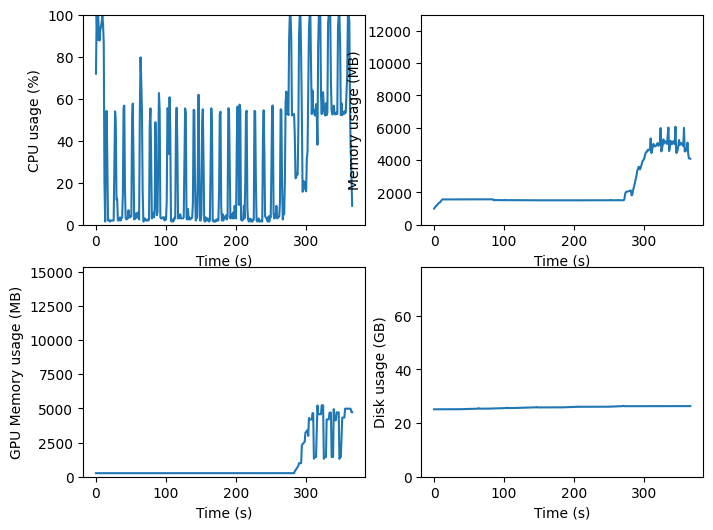

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 7.61s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 7.61s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 7.61s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 7.61s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 7.61s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...


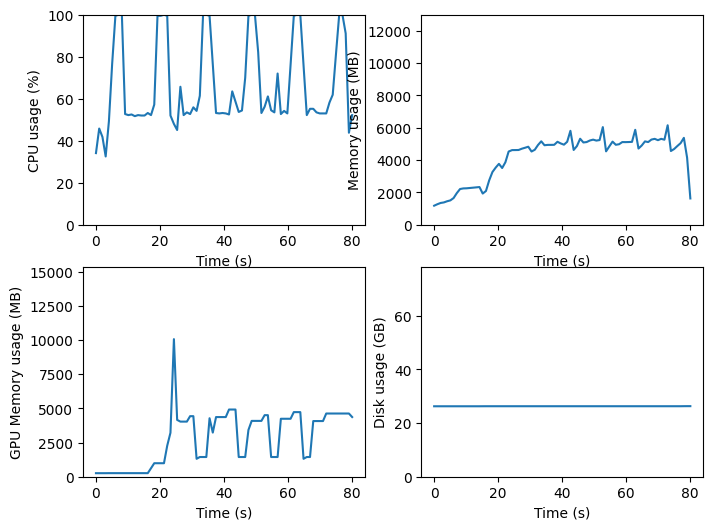

Processing series: 1.2.840.113654.2.55.100875189782210690344207306235124901243

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.84s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.84s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.84s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.84s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.84s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

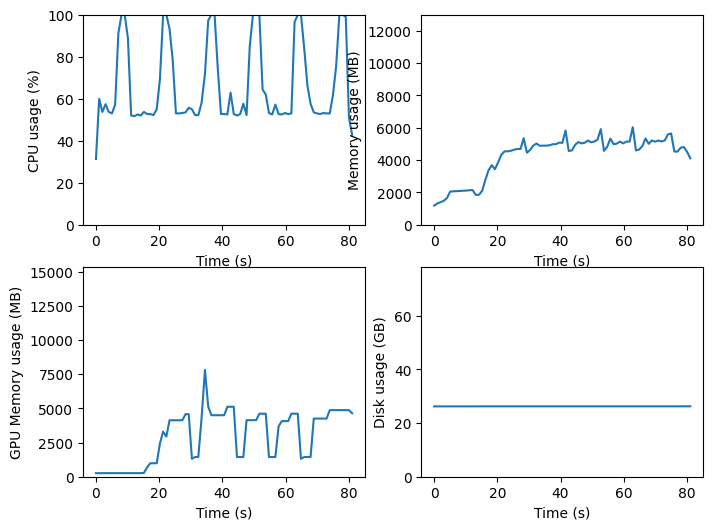

Processing series: 1.2.840.113654.2.55.142419057730651121165090739113900499978

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.51s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.51s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.51s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.51s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.51s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

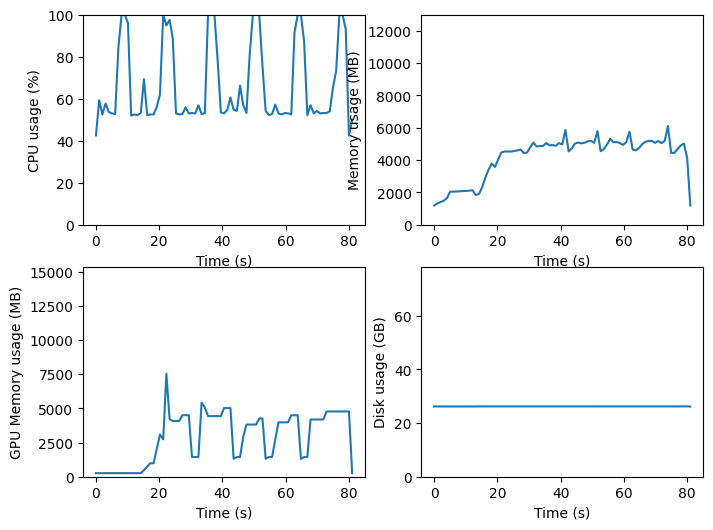

Processing series: 1.2.840.113654.2.55.243990451406006403331425809632881193215

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.58s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.58s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.58s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.58s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.58s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

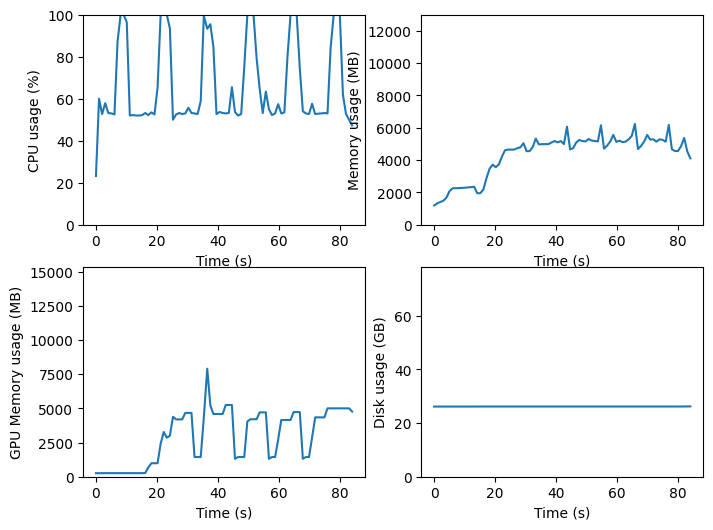

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.77s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.77s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.77s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.77s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.77s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...


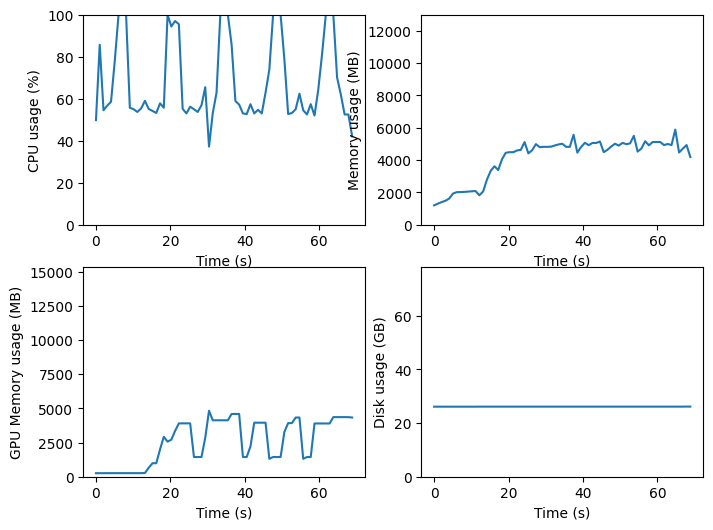

Processing series: 1.2.840.113654.2.55.14382674871619950799472325766084940706

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.99s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.99s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.99s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.99s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 6.99s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predic

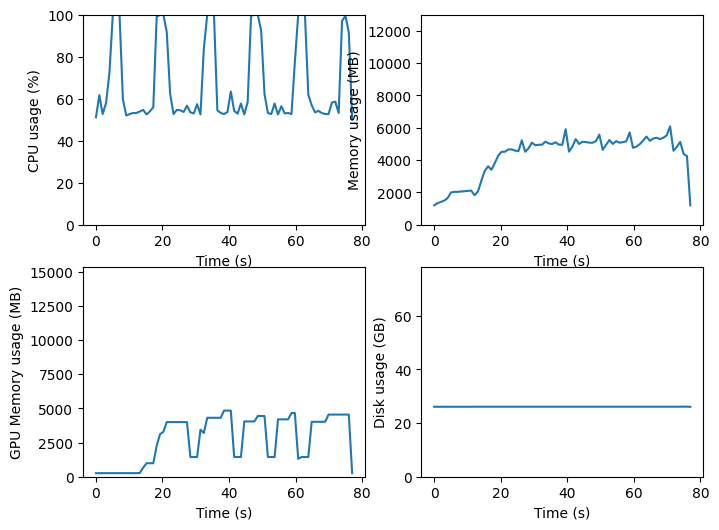

Processing series: 1.2.840.113654.2.55.146601594654322994982630019583270053397

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.09s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.09s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.09s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.09s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.09s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

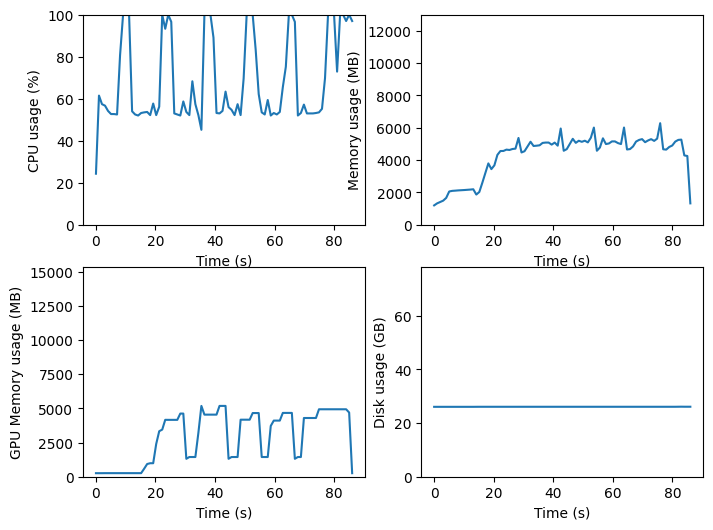

Processing series: 1.2.840.113654.2.55.113040386178547843571271236478024341696

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.62s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.62s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.62s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.62s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.62s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

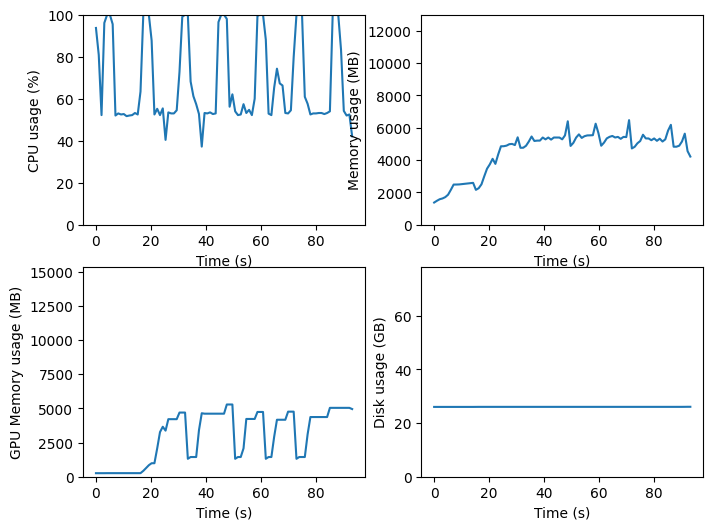

Processing series: 1.2.840.113654.2.55.185309182591805634517860395342326800332

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.02s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.02s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.02s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.02s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.02s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

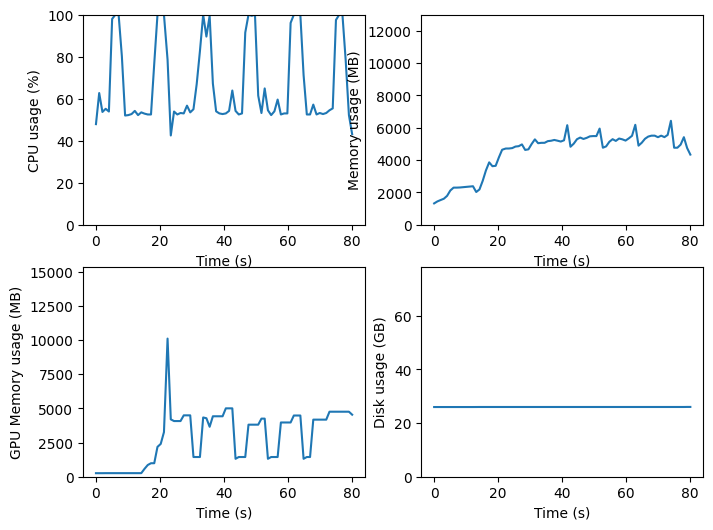

Processing series: 1.2.840.113654.2.55.216614002338888733987350522981366678482

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.00s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.00s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.00s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.00s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 8.00s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

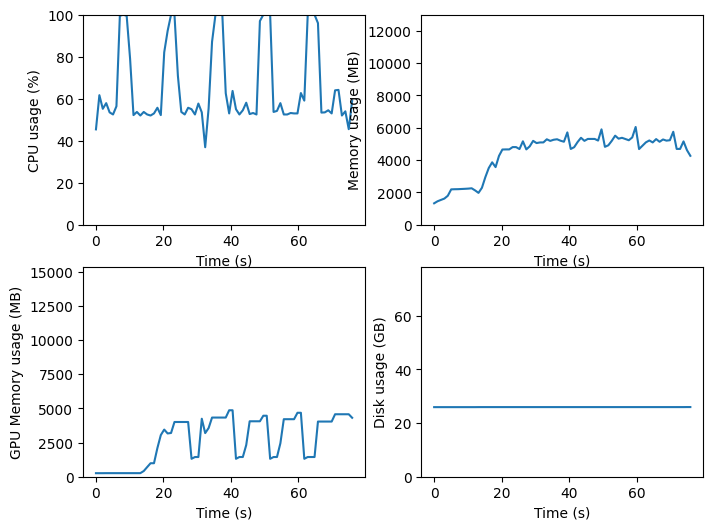

Processing series: 1.2.840.113654.2.55.154809705591242159075253605419469935510

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 4.92s
Predicting part 1 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 4.92s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 4.92s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 4.92s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 4.92s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predi

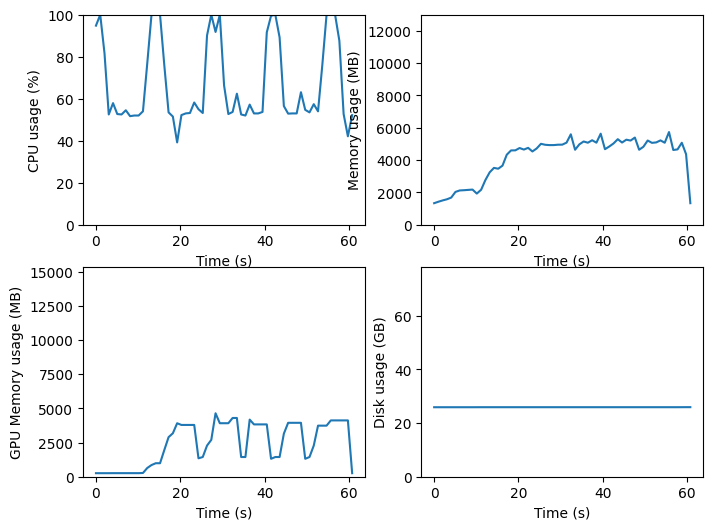

In [ ]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
  #os.remove('metadata.tar.lz4')
except OSError:
  pass
!tar cvf - -C {curr_dir} Inference | lz4 > inferenceNiftiFiles.tar.lz4
#!tar cvf - -C {curr_dir} metadata | lz4 > inferenceMetaData.tar.lz4
archiving_time = time.time() - start_time


Inference/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345.nii.lz4
Inference/1.2.840.113654.2.55.100875189782210690344207306235124901243/
Inference/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243.nii.lz4
Inference/1.2.840.113654.2.55.142419057730651121165090739113900499978/
Inference/1.2.840.113654.2.55.142419057730651121165090739113900499978/1.2.840.113654.2.55.142419057730651121165090739113900499978.nii.lz4
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/

###**Utilization Metrics**

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 64375 bytes into 21251 bytes ==> 33.01%


,SeriesInstanceUID,total_segmentator_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total
0,1.2.840.113654.2.55.22770087029972268579113866...,366.594260,0.116195,"[[[71.9, 100.0, 88.1, 100.0, 92.6, 87.7, 92.6,...","[[[997.234375, 1071.7109375, 1134.0078125, 116...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[25.102397918701172, 25.102401733398438, 25....",78.189842
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529...,80.124021,0.116195,"[[[34.1, 45.8, 41.8, 32.5, 49.3, 76.6, 99.5, 1...","[[[1176.30078125, 1267.91796875, 1345.3984375,...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[26.231258392333984, 26.231258392333984, 26....",78.189842
2,1.2.840.113654.2.55.10087518978221069034420730...,81.488889,0.116195,"[[[31.3, 59.9, 53.7, 57.4, 53.7, 53.0, 57.2, 9...","[[[1185.40234375, 1312.6015625, 1395.09765625,...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.192466735839844, 26.19247055053711, 26.1...",78.189842
3,1.2.840.113654.2.55.14241905773065112116509073...,80.728143,0.116195,"[[[42.5, 59.3, 52.5, 57.7, 53.7, 53.0, 52.7, 8...","[[[1189.51171875, 1318.4296875, 1402.5546875, ...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.159561157226562, 26.159564971923828, 26....",78.189842
4,1.2.840.113654.2.55.24399045140600640333142580...,84.563727,0.116195,"[[[23.2, 60.0, 52.7, 57.9, 53.2, 53.0, 52.5, 8...","[[[1191.5, 1320.69140625, 1405.30078125, 1484....",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.125289916992188, 26.125293731689453, 26....",78.189842
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401...,69.442422,0.116195,"[[[49.8, 85.7, 54.5, 56.7, 58.6, 78.1, 100.0, ...","[[[1197.37109375, 1303.4453125, 1401.234375, 1...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.080982208251953, 26.080982208251953, 26....",78.189842
6,1.2.840.113654.2.55.14382674871619950799472325...,76.644137,0.116195,"[[[51.2, 61.7, 52.7, 58.0, 72.4, 100.0, 100.0,...","[[[1199.94140625, 1328.8671875, 1411.70703125,...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.05517578125, 26.055179595947266, 26.0551...",78.189842
7,1.2.840.113654.2.55.14660159465432299498263001...,85.800347,0.116195,"[[[24.3, 61.5, 57.4, 56.7, 54.2, 52.7, 52.7, 5...","[[[1195.359375, 1322.21484375, 1404.625, 1488....",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.024791717529297, 26.024795532226562, 26....",78.189842
8,1.2.840.113654.2.55.11304038617854784357127123...,93.638876,0.116195,"[[[93.7, 80.9, 52.2, 96.1, 100.0, 100.0, 95.5,...","[[[1371.703125, 1480.8359375, 1576.703125, 162...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[25.992206573486328, 25.992210388183594, 25....",78.189842
9,1.2.840.113654.2.55.18530918259180563451786039...,80.498956,0.116195,"[[[47.9, 62.7, 53.7, 55.2, 53.9, 98.0, 100.0, ...","[[[1318.578125, 1441.11328125, 1526.19140625, ...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[25.947219848632812, 25.947223663330078, 25....",78.189842
